
# ✉️ SMS Spam Detection — Google Colab (UCI SMS Spam Collection)

A compact **security ML demo**: detect **spam vs ham** SMS messages using the **UCI SMS Spam Collection** dataset.

**What you'll see**
- Download + unzip from UCI
- Text preprocessing with scikit‑learn `TfidfVectorizer`
- Train Logistic Regression (toggle LinearSVC / RandomForest)
- Evaluate: accuracy, precision, recall, F1, ROC‑AUC
- Visuals: confusion matrix + ROC
- **Concrete examples**: TP/TN/FP/FN messages for presentation

> Official dataset: UCI ML Repository — SMS Spam Collection.


In [1]:

#@title Setup
import os, sys, io, zipfile, urllib.request, re, string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, accuracy_score, roc_auc_score, roc_curve, confusion_matrix
)

print("Python:", sys.version.split()[0])
import sklearn, pandas, numpy
print("scikit-learn:", sklearn.__version__)
print("pandas:", pandas.__version__)
print("numpy:", numpy.__version__)


Python: 3.12.12
scikit-learn: 1.6.1
pandas: 2.2.2
numpy: 2.0.2


In [2]:

#@title Download and unzip the dataset (UCI official)
URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"
ZIP_PATH = "smsspamcollection.zip"
TXT_PATH = "SMSSpamCollection"

if not os.path.exists(ZIP_PATH):
    print("Downloading zip...")
    urllib.request.urlretrieve(URL, ZIP_PATH)
else:
    print("Found zip, skipping download.")

if not os.path.exists(TXT_PATH):
    print("Extracting...")
    with zipfile.ZipFile(ZIP_PATH, "r") as zf:
        zf.extractall(".")
else:
    print("Found extracted dataset.")

print("Ready:", os.path.exists(TXT_PATH))


Extracting...
Ready: True


In [3]:

#@title Load data into pandas
# File format: "label<TAB>message"
rows = []
with open("SMSSpamCollection", "r", encoding="utf-8") as f:
    for line in f:
        parts = line.rstrip("\n").split("\t", 1)
        if len(parts) == 2:
            rows.append(parts)
df = pd.DataFrame(rows, columns=["label","text"])

# Map label to y: spam=1, ham=0
df["y"] = (df["label"].str.lower() == "spam").astype(int)

print(df.shape, df["label"].value_counts())
df.head(3)


(5574, 3) label
ham     4827
spam     747
Name: count, dtype: int64


,label,text,y
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1


In [4]:

#@title Train/test split and choose model
X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["y"].values, test_size=0.25, random_state=42, stratify=df["y"].values
)

#@markdown Choose your classifier:
clf_choice = "LogisticRegression"  #@param ["LogisticRegression", "LinearSVC", "RandomForest"]
C_value = 2.0  #@param {type:"number"}

if clf_choice == "LogisticRegression":
    clf = LogisticRegression(max_iter=1000, C=C_value)
    need_calibration = False
elif clf_choice == "LinearSVC":
    base = LinearSVC(C=C_value)
    # Calibrate to get probability estimates for ROC
    clf = CalibratedClassifierCV(base, method="sigmoid", cv=5)
    need_calibration = True
else:
    clf = RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1)
    need_calibration = False

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.98)),
    ("clf", clf)
])

pipe.fit(X_train, y_train)
train_pred = pipe.predict(X_train)
test_pred  = pipe.predict(X_test)

print(f"Train acc: {accuracy_score(y_train, train_pred):.4f}")
print(f"Test  acc: {accuracy_score(y_test,  test_pred):.4f}")
print()
print("Classification report (test):")
print(classification_report(y_test, test_pred, digits=4))


Train acc: 0.9885
Test  acc: 0.9806

Classification report (test):
              precision    recall  f1-score   support

           0     0.9781    1.0000    0.9889      1207
           1     1.0000    0.8556    0.9222       187

    accuracy                         0.9806      1394
   macro avg     0.9891    0.9278    0.9556      1394
weighted avg     0.9811    0.9806    0.9800      1394



Test ROC-AUC: 0.9925


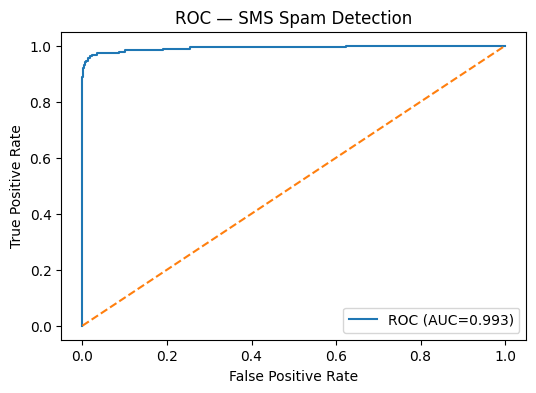

In [5]:

#@title ROC-AUC + ROC curve
# Get scores
if hasattr(pipe.named_steps["clf"], "predict_proba"):
    test_proba = pipe.predict_proba(X_test)[:,1]
else:
    # For calibrated LinearSVC, decision_function is present on the inner estimator
    if hasattr(pipe.named_steps["clf"], "decision_function"):
        raw = pipe.decision_function(X_test)
    else:
        # fallback: try predict_proba; if both missing, use predictions
        raw = test_pred.astype(float)
    raw = np.asarray(raw).ravel()
    raw_min, raw_max = raw.min(), raw.max()
    test_proba = (raw - raw_min) / (raw_max - raw_min + 1e-12)

auc = roc_auc_score(y_test, test_proba)
print(f"Test ROC-AUC: {auc:.4f}")

fpr, tpr, thr = roc_curve(y_test, test_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC — SMS Spam Detection")
plt.legend(loc="lower right")
plt.show()


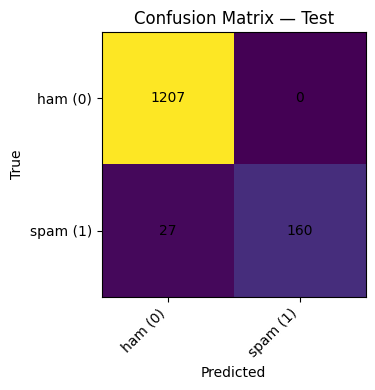

(array([[1207,    0],
        [  27,  160]]),
 array(['ham (0)', 'spam (1)'], dtype='<U8'))

In [6]:

#@title Confusion Matrix (test)
cm = confusion_matrix(y_test, test_pred)
classes = np.array(["ham (0)","spam (1)"])

plt.figure(figsize=(4,4))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix — Test")
plt.xticks([0,1], classes, rotation=45, ha="right")
plt.yticks([0,1], classes)
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

cm, classes



## 🧪 Concrete examples (TP/TN/FP/FN)
See **actual messages** the model labeled as **spam** vs **ham**, and where it was wrong.


In [7]:

#@title Build example buckets and show tables
import pandas as pd
from IPython.display import display

def collect_examples(text_series, y_true, y_pred, proba=None, max_rows=6):
    idx_all = np.arange(len(y_true))
    is_pos = y_true == 1
    is_neg = ~is_pos

    tp_idx = idx_all[(y_pred == 1) & is_pos]
    tn_idx = idx_all[(y_pred == 0) & is_neg]
    fp_idx = idx_all[(y_pred == 1) & is_neg]
    fn_idx = idx_all[(y_pred == 0) & is_pos]

    def build_df(indices):
        take = indices[:max_rows]
        out = pd.DataFrame({
            "y_true": y_true[take],
            "y_pred": y_pred[take],
            "text": text_series.iloc[take].values
        })
        if proba is not None:
            out.insert(2, "p(spam)", np.asarray(proba)[take])
        return out.reset_index(drop=True)

    return {
        "TP (spam correctly detected)": build_df(tp_idx),
        "TN (ham correctly detected)": build_df(tn_idx),
        "FP (ham flagged as spam)": build_df(fp_idx),
        "FN (missed spam)": build_df(fn_idx),
    }

examples = collect_examples(X_test.reset_index(drop=True), y_test, test_pred, proba=test_proba, max_rows=6)

print("TP — spam correctly detected")
display(examples["TP (spam correctly detected)"])

print("TN — ham correctly detected")
display(examples["TN (ham correctly detected)"])

print("FP — ham flagged as spam")
display(examples["FP (ham flagged as spam)"])

print("FN — missed spam")
display(examples["FN (missed spam)"])


TP — spam correctly detected


,y_true,y_pred,p(spam),text
0,1,1,0.748825,"""URGENT! This is the 2nd attempt to contact U!..."
1,1,1,0.906975,Free 1st week entry 2 TEXTPOD 4 a chance 2 win...
2,1,1,0.834245,Todays Voda numbers ending with 7634 are selec...
3,1,1,0.894349,December only! Had your mobile 11mths+? You ar...
4,1,1,0.865666,You are now unsubscribed all services. Get ton...
5,1,1,0.751484,FREE entry into our £250 weekly comp just send...


TN — ham correctly detected


,y_true,y_pred,p(spam),text
0,0,0,0.065885,What is the plural of the noun research?
1,0,0,0.012802,Ok lor.
2,0,0,0.005764,Its a big difference. &lt;#&gt; versus &lt;...
3,0,0,0.037503,"Come to me right now, Ahmad"
4,0,0,0.053564,Sun cant come to earth but send luv as rays. c...
5,0,0,0.017895,Haf u found him? I feel so stupid da v cam was...


FP — ham flagged as spam


,y_true,y_pred,p(spam),text


FN — missed spam


,y_true,y_pred,p(spam),text
0,1,0,0.191718,Download as many ringtones as u like no restri...
1,1,0,0.199835,"0A$NETWORKS allow companies to bill for SMS, s..."
2,1,0,0.050080,Hi ya babe x u 4goten bout me?' scammers getti...
3,1,0,0.379338,Your weekly Cool-Mob tones are ready to downlo...
4,1,0,0.371691,"cmon babe, make me horny, *turn* me on! Txt me..."
5,1,0,0.266995,More people are dogging in your area now. Call...



## 📊 Quick presentation visuals
Top word features (unigrams/bigrams) for the TP and TN samples shown above.


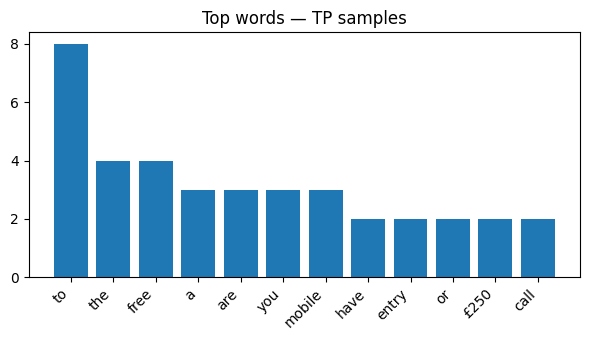

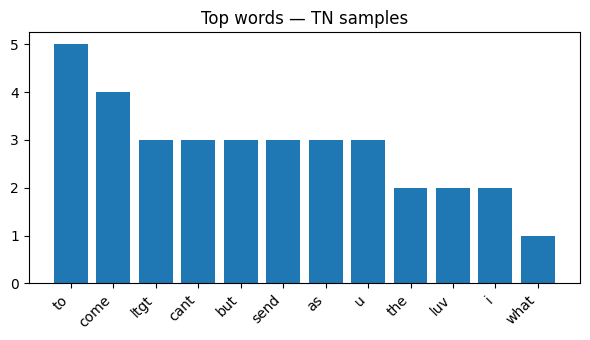

In [8]:

#@title Simple word-frequency bars for the visualized samples
from collections import Counter

def tokenize_simple(s: str):
    s = s.lower()
    s = re.sub(r"http\\S+|www\\S+", " URL ", s)
    s = s.translate(str.maketrans("", "", string.punctuation))
    return [w for w in s.split() if w and not w.isdigit()]

def top_words(df, k=12):
    all_tokens = []
    for txt in df["text"].tolist():
        all_tokens.extend(tokenize_simple(txt))
    cnt = Counter(all_tokens)
    return cnt.most_common(k)

def plot_top_words(pairs, title):
    if not pairs:
        print("No words to plot for", title)
        return
    words, freqs = zip(*pairs)
    idx = np.arange(len(words))
    plt.figure(figsize=(6,3.5))
    plt.bar(idx, freqs)
    plt.xticks(idx, words, rotation=45, ha="right")
    plt.title(title)
    plt.tight_layout()
    plt.show()

tp = examples["TP (spam correctly detected)"]
tn = examples["TN (ham correctly detected)"]

plot_top_words(top_words(tp, k=12), "Top words — TP samples")
plot_top_words(top_words(tn, k=12), "Top words — TN samples")
